# 2.0 NLP

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

### 2.1 Set Up

In [1]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import os

In [2]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

In [ ]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [4]:
#Configure
#nltk.download('wordnet') # <-- These are done in a supporting tool, but in your own
#nltk.download('averaged_perceptron_tagger') # application you'd need to import them
stopword_list = set(stopwords.words('english'))

In [5]:
#Function to output Markdown

from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

In [6]:
import urllib.request
host  = 'https://orca.casa.ucl.ac.uk'
turl  = f'{host}/~jreades/__textual__.py'
tdirs = os.path.join('textual')
tpath = os.path.join(tdirs,'__init__.py')

if not os.path.exists(tpath):
    os.makedirs(tdirs, exist_ok=True)
    urllib.request.urlretrieve(turl, tpath)

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from textual import *

All NLTK libraries installed...


### 2.2 Reading In

In [9]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Reading in listings data 
Two files read in: One pre-processed with NLP and one without

In [10]:
# Reading in listings data with NLP
listings_nlp = gpd.read_feather("data/2022-09-10-listings-with-nlp.geofeather")
listings_nlp.shape

(67475, 7)

In [11]:
# Reading in listings data without NLP
listings = gpd.read_feather(("data/2022-09-10-listings.geofeather"), columns= ['index', 'geometry', 'id', 'listing_url', 'name', 
                               'description', 'amenities', 'price', 'host_total_listings_count']).set_index('id')
listings.shape

(68741, 8)

In [ ]:
# listings = pd.merge(listings, listings_nlp[['index', 'description_norm']], on = 'index', how = 'left')
# listings.head(2)

In [12]:
# Read in London boundaries
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/Boroughs.gpkg locally!
Found data/Water.gpkg locally!
Found data/Greenspace.gpkg locally!
Done.


In [13]:
print(f"gdf has {listings.shape[0]:,} rows.")

gdf has 68,741 rows.


In [14]:
listings = listings.to_crs('epsg:27700')

### 2.3 Remove NaN Values

In [15]:
listings = listings.dropna(subset=['description','amenities'])
print(f"Now gdf has {listings.shape[0]:,} rows.")

Now gdf has 67,475 rows.


### 2.4 Description Field

In [16]:
listings.description.sample(5, random_state=42)

id
699053507371704448                                Recently refurbished.
53382856              ✪ MARCH BOOKINGS - DISCOUNTED RATES ✪<br /><br...
21068222              Beautiful, newly redecorated period house, wit...
25912554              Welcome to Applecourt, a lovely self-contained...
30814423              Stunning one bed room flat in the heart of vib...
Name: description, dtype: object

### 2.5 Creating RegEx

In [17]:
#Increase column width
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   

Default maximum column width: 50


In [18]:
#Cultural REGEX
# clt_listings = listings[listings.description.str.contains(r'vibrant|young|exciting|nightlife|night life|art', regex=True, flags=re.IGNORECASE)].copy()

clt_listings = listings[listings.description.str.contains(r'theatre|dance|night clubs| music venue', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {clt_listings.shape[0]:,} records for 'cultural' listings")

Found 2,375 records for 'cultural' listings


Almost all listings have the word culture/cutural in its description

In [19]:
listings.shape[0]

67475

### 2.5.1 Plot clt_listings

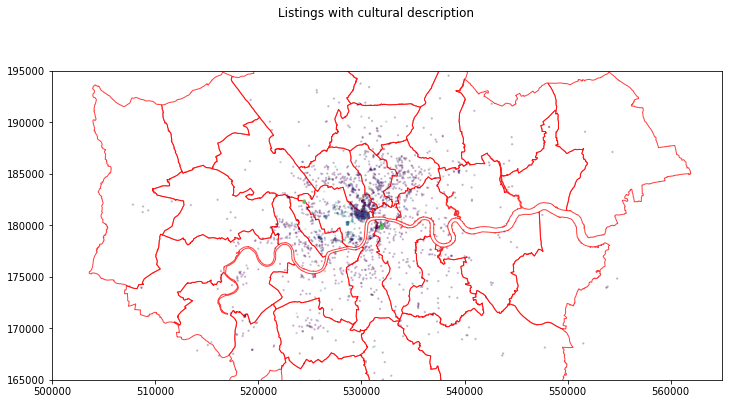

In [20]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# Map
ax1 = plt.subplot2grid((4,1), (0,0), rowspan= 3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
clt_listings.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# # Histogram
# ax2 = plt.subplot2grid((4,1), (3,0), rowspan= 1)
# clt_listings.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings with cultural description") # <-- How does this differ from title? Change it and see!
# plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()

## Host count
We'll use this for NLP on casual vs professional hosts when we get there

In [21]:
#Converting the total_listing_count column to numpy array for manipulation
host_count = np.array(listings['host_total_listings_count'].values.tolist())

In [22]:
host_count[host_count > 1] = 0 #Changing any values above 1 to 0. Meaning "not casual" (professional).

In [23]:
listings['casual_or_prof'] = host_count #Creating a new column which identifies if a listings host is casual (1 listing), or professional (>1 listing)

In [24]:
casual_hosts = listings[listings['casual_or_prof'] == 1]
casual_hosts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23704 entries, 107051 to 49698549
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   index                      23704 non-null  int64   
 1   geometry                   23704 non-null  geometry
 2   listing_url                23704 non-null  object  
 3   name                       23693 non-null  object  
 4   description                23704 non-null  object  
 5   amenities                  23704 non-null  object  
 6   price                      23704 non-null  float64 
 7   host_total_listings_count  23704 non-null  int64   
 8   casual_or_prof             23704 non-null  int64   
dtypes: float64(1), geometry(1), int64(3), object(4)
memory usage: 1.8+ MB


## Applying normalisation
Now applying normalisation on cultural listings

In [32]:
srcdf = clt_listings # <-- you only need to change the value here to try the different selections

In [34]:
%%time 
srcdf['description_norm'] = srcdf.description.apply(normalise_document, remove_digits=True)

CPU times: user 1min 4s, sys: 493 ms, total: 1min 5s
Wall time: 1min 5s


In [35]:
corpus = srcdf.description_norm.fillna(' ').values
print(corpus[0:3])

['city london flat private balcony  tower london amenity mins walk tower hill tube . pubs  cafe  restaurant  supermarket  food market famous site close . plenty linen  towel  space flat . approx .  . private balcony  city london . flat near river thames  metres tower london surround capital famous sight include tower london tower bridge . site include paul cathedral  tate modern  globe theatre  south bank arts centre  gherkin . fantastic base explore capital major attraction . shakespeare globe theatre definitely worth visit trip west  varied production year round . flat meter tower london tower bridge'
 'large  light spacious loft bedroom newly decorate ensuite shower room minute tube hammersmith . space provide large double bedroom suit either couple small family travel together . bedroom bedroom house currently live . make stay london comfortable pleasant possible take away wonderful memory stay visit  hope able point best foodie place  unique market even touristy spot . sightsee lo

In [36]:
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

In [37]:
print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")

Sentences 0: ['city london flat private balcony  tower london amenity mins walk tower hill tube .', 'pubs  cafe  restaurant  supermarket  food market famous site close .', 'plenty linen  towel  space flat .', 'approx .  . private balcony  city london .', 'flat near river thames  metres tower london surround capital famous sight include tower london tower bridge .', 'site include paul cathedral  tate modern  globe theatre  south bank arts centre  gherkin .', 'fantastic base explore capital major attraction .', 'shakespeare globe theatre definitely worth visit trip west  varied production year round .', 'flat meter tower london tower bridge']

Words 0: [['city', 'london', 'flat', 'private', 'balcony', 'tower', 'london', 'amenity', 'mins', 'walk', 'tower', 'hill', 'tube', '.'], ['pubs', 'cafe', 'restaurant', 'supermarket', 'food', 'market', 'famous', 'site', 'close', '.'], ['plenty', 'linen', 'towel', 'space', 'flat', '.'], ['approx', '.', '.', 'private', 'balcony', 'city', 'london', '.']

## Frequencies and Ngrams

In [38]:
fcounts = dict()

# Here we replace all full-stops... can you think why we might do this?
data = nltk.tokenize.word_tokenize(' '.join([text.replace('.','') for text in corpus]))

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one note this: https://stackoverflow.com/a/52193485/4041902
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 7217 samples and 176803 outcomes>
<FreqDist with 62818 samples and 176802 outcomes>
<FreqDist with 103864 samples and 176801 outcomes>


In [39]:
print(fcounts)

{1:            Ngram Size 1
a                     1
abba                  1
abbey                45
abbeywood             2
ability               2
...                 ...
ziggy                 1
zona                  1
zone                287
zulu                  1
zwave                 1

[7217 rows x 1 columns], 2:                   Ngram Size 2
a     station                1
abba  theatre                1
abbey apartment              2
      buckingham            10
      churchill              6
...                        ...
zone  westbourne             1
      wimbledon              1
      with                   1
zulu  daily                  1
zwave whether                1

[62818 rows x 1 columns], 3:                              Ngram Size 3
a     station    overground             1
abba  theatre    walk                   1
abbey apartment  fully                  2
      buckingham palace                10
      churchill  rooms                  6
...                      

In [40]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

           Ngram Size 1
london             2914
space              2842
room               2564
walk               2217
apartment          2136
bedroom            1974
kitchen            1633
minute             1567
flat               1561
area               1540

                  Ngram Size 2
minute  walk               955
guest   access             641
central london             618
thing   note               541
living  room               489
covent  garden             471
walk    distance           407
double  bedroom            378
heart   london             339
please  note               319

                                        Ngram Size 3
please       note         conditioning           199
note         conditioning available              198
available    room         space                  198
conditioning available    room                   198
shakespear   globe        theatre                183
fully        equip        kitchen                182
street       oxford   

In [41]:
cvectorizer = CountVectorizer(ngram_range=(1,3))
cvectorizer.fit(corpus)

CountVectorizer(ngram_range=(1, 3))

In [42]:
term = 'club'
pd.options.display.max_colwidth=750
# Find the vocabulary mapping for the term
print(f"Vocabulary mapping for {term} is {cvectorizer.vocabulary_[term]}")
# How many times is it in the data
print(f"Found {srcdf.description_norm.str.contains(term).sum():,} rows containing {term}")
# Print the descriptions containing the term
as_markdown('Club',srcdf[srcdf.description_norm.str.contains(term)].description_norm)

Vocabulary mapping for club is 30776
Found 171 rows containing club


##### Club

>id
81473                                                                                                                                                                           space kitchen double free wifi connection throughout house room  germaneuropean channel available kitchen available . washing machinedish washermicrowave . share bathroom owner free park crystal palace park minute walk away . jogging nice walk . crystal palace national sports center meter pool  walk gorgeous . rent part household . property suitable anybody allergy  . linen towel available include guest access bedroom  kitchendiner  bathroom . share . thing note live london around year many trick  clubs  theatre alternative sightseeing . 
470503                                                        convert warehouse heart trendy dalston  cafe  restaurant  culture easy transport link . small charm flat  ideal people short trip london . space convert warehouse heart trendy dalston  cafe  turkish restaurant  funky  vortex jazz club  cinema  arcola theatre  ridley road street market week  large supermarket excellent transport link short walk  dalston kingsland minute away foot  link victoria line tube highbury islington minute  stratford minute . central london minute away . dalston junction also close  minute walk  allow train south . also many night . dalston zone . high ceiling  wooden floor  original metal column outdoor terrace make onebedroom
475700                                                                                                                                      space beautiful studio apartment centre camden town . studio flat floor house  share front door stair accommodation self contain . large sunny room window overlook pretty garden . double  kitchen area halogen  microwave oven fridge .  radio wifi . also bathroom showerbath . camden town great place everything need within easy reach . within minute regent park  london  wander round camden lock market . huge choice place drink  well live music night club . west shop  gallery  theatre cinema minute away . minute walk pancras international . hand advise anything need know camden
521982                                        willing take night booking appropriate  please touch booking night space apartment fantastic location . great area stay abundance thing right doorstep . lots wonderful coffee shop  quirky boutique  great choice restaurant club  fantastic independent cinema cosy sofa great gallery within walk distance . minute walk shoreditch station . good connection stratford . stop away . minute liverpool street . everything doorstep within walk distance . brick lane array curry house spitalfields close . wonderful flower market minute away sunday well worth visit double bedroom twin room would sleep four comfortably  extra guest possible . great view london . thing note apartment
591837                                                                    space large bedroom flat typical white victrian building face best part hyde park  call kensington garden  view kensington palace  soon become home kate william baby  situate hyde street  kensington  close amenity include whole food large distributor . high street walk distance notting hill south kensington chelsea high street great nightlife best restaurant  night club   hotel . local area great transportation link  short walk high street kensington underground station . access circle district lines . area also serve numerous  include night  mean easily around  matter time  large bedroom  large reception bathroom amazing view park window
                                                                                                                                                                                                                                                                                                                                                                                 ...                                                                                                                                                                                                                                                                                                                                                            
684306365749747584                                                                    best soho central location  heart central london bedrooms double sofa . sleeps . bathrooms safe secure location smart  netflix . guest . highspeed wifi wellequipped kitchen nespresso coffee machine space heart london  apartment everything doorstep . along rich heritage  restaurant  club   eclectic range theatre  spoil worldclass shopping international dining option . central london attraction include piccadilly circus  oxford street  regent street  london   buckingham palace  british museum  tate gallery  others within walk distance . sleeps double bedrooms double sofa bed bathrooms smart  netflix . guest . highspeed unlimited
687341641613743488                                                                                                                                                                                                                                                         topfloor flat  location  situate london soho  short walk numerous  restaurant  nightclub  theatre . ideal single traveler couple  flat offer modern facility  fully equip kitchen  modern bathroom  spacious lounge  bedroom . wifi throughout plasma tvs.piccadilly tube station minute walk property . space flat consist spacious loungediner  fully equip bathroom walkin shower  bedroom . underfloor heating  wifi throughout . guest access entire apartment .
689029565308213120    beautifully design spacious family home room available  locate centrally peckham  zone london close park  shop   club  restaurant transport perfect london city break . welllocated  comfortable house  perfect explore vibrant area . minute away south bank . culture  theatre  tate modern .  borough market  shard thames riverside . space welcome home  bedroom family house locate heart peckham  vibrant part southeast london . victorian property large  airy bright plenty space enjoy relax . hallway entrance lead highceilinged space stylish lounge . area large  comfortable sofa   bookshelf fireplace . second lounge armchair  piano delightful window seat look onto courtyard garden . along corridor
696068011450142848                                                                                                                                                                                                                                                                                                                                                                                     spacious bedroom apartment everything need london trip . unit come wifi  workspace  coffee maker essential need . stay  also enjoy convenient ensuite bedroom fully equip kitchen . dining table four along sofa back relax living room . airbnb within walk distance several popular shop  coffee shop  night club beautiful shoreditch 
704175031249100672                                                                                                                                                                                                                                                                                                                                                                                                            welcome camden town londo vibrant shopping entertainment neighborhood  complete famous market fashion curiosity locate regen canal . bedroom flat locate tube station close central london . separate living room sofa  kitchen bathroom . camden perfect place lively night london . nightclub music venue . miss
Name: description_norm, Length: 171, dtype: object


In [43]:
cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

<2375x168136 sparse matrix of type '<class 'numpy.int64'>'
	with 489769 stored elements in Compressed Sparse Row format>

In [44]:
doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(10)

,Counts
tower,7
london,6
tower london,4
flat,4
balcony,2
private balcony,2
city london,2
city london flat,2
include,2
private,2


In [45]:
cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:5,0:10]

Raw count vectorised data frame has 2,375 rows and 168,136 columns.


,abba,abba theatre,abba theatre walk,abbey,abbey apartment,abbey apartment fully,abbey buckingham,abbey buckingham palace,abbey churchill,abbey churchill rooms
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [46]:
sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

There are 168,136 terms in the data set.


abba                  1
abba theatre          1
abba theatre walk     1
abbey                45
abbey apartment       2
dtype: int64

In [47]:
filter_terms = sums >= cvdf.shape[0] * 0.01

In [48]:
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:5,0:10]

Filtered count vectorised data frame has 2,375 rows and 1,989 columns.


,abbey,able,abundance,abundance light,abundance light stylish,abundance natural,abundance natural light,abundance restaurant,abundance space,access
0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [49]:
fcvdf.sum(axis=0)

abbey                        45
able                         59
abundance                   592
abundance light              89
abundance light stylish      58
                           ... 
year                         85
young                        45
zone                        287
zone provide                175
zone provide opportunity    175
Length: 1989, dtype: int64

In [50]:
tfvectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), 
                               max_df=0.75, min_df=0.01) # <-- these matter!
tftcorpus    = tfvectorizer.fit_transform(corpus) # TF-transformed corpus

In [51]:
doc_df = pd.DataFrame(tftcorpus[0].T.todense(), index=tfvectorizer.get_feature_names_out(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

,Weights
tower,0.639503
private balcony,0.208373
tower bridge,0.198501
capital,0.195372
site,0.185701
city london,0.179286
flat,0.159100
london,0.153146
balcony,0.138601
globe theatre,0.130701


In [52]:
tfidf = pd.DataFrame(data=tftcorpus.toarray(),
                        columns=tfvectorizer.get_feature_names_out())
print(f"TF/IDF data frame has {tfidf.shape[0]:,} rows and {tfidf.shape[1]:,} columns.")
tfidf.head()

TF/IDF data frame has 2,375 rows and 1,917 columns.


,abbey,able,abundance,abundance light,abundance light stylish,abundance natural,abundance natural light,abundance restaurant,abundance space,access,...,worldclass shopping international,would,would need,would need inform,yard,year,young,zone,zone provide,zone provide opportunity
0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.084253,0.000000,0.000000,0.0,0.0
1,0.0,0.264812,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.115378,0.000000,0.0,0.0
3,0.0,0.000000,0.06919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.085998,0.0,0.0
4,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.086064,0.0,0.0


In [53]:
fcvdf.sum().sort_values(ascending=False)

london            2923
space             2843
room              2566
walk              2220
apartment         2137
                  ... 
option central      24
twobedroom          24
currently           24
beautiful view      24
walk covent         24
Length: 1989, dtype: int64

## Word2Vec

In [55]:
from gensim.models.word2vec import Word2Vec

In [56]:
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 3
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.005 # Don't keep words appearing less than 0.5% frequency
min_v_count = math.ceil(min_v_freq * srcdf.shape[0])
print(f"With a minimum frequency of {min_v_freq} and {srcdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")


You've chosen 100 dimensions.
You've chosen a window of size 3.
With a minimum frequency of 0.005 and 2,375 documents, minimum vocab frequency is 12.


In [57]:
%%time 

corpus      = srcdf.description_norm.fillna(' ').values
#corpus_sent = [nltk.sent_tokenize(text) for text in corpus] # <-- with more formal writing this would work well
corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=corpus_sent, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora

CPU times: user 1min 36s, sys: 2.02 s, total: 1min 38s
Wall time: 1min 36s


In [58]:
pd.set_option('display.max_colwidth',150)

df = fcounts[1] # <-- copy out only the unigrams as we haven't trained anything else

n     = 14 # number of words
topn  = 7  # number of most similar words

selected_words = df[df['Ngram Size 1'] > 5].reset_index().level_0.sample(n, random_state=42).tolist()

words = []
v1    = []
v2    = []
v3    = []
sims  = []

for w in selected_words:
    try: 
        vector = model.wv[w]  # get numpy vector of a word
        #print(f"Word vector for '{w}' starts: {vector[:5]}...")
    
        sim = model.wv.most_similar(w, topn=topn)
        #print(f"Similar words to '{w}' include: {sim}.")
    
        words.append(w)
        v1.append(vector[0])
        v2.append(vector[1])
        v3.append(vector[2])
        sims.append(", ".join([x[0] for x in sim]))
    except KeyError:
        print(f"Didn't find {w} in model. Can happen with low-frequency terms.")
    
vecs = pd.DataFrame({
    'Term':words,
    'V1':v1, 
    'V2':v2, 
    'V3':v3,
    f'Top {topn} Similar':sims
})

vecs

Didn't find approve in model. Can happen with low-frequency terms.
Didn't find excellently in model. Can happen with low-frequency terms.
Didn't find departure in model. Can happen with low-frequency terms.
Didn't find depend in model. Can happen with low-frequency terms.
Didn't find proper in model. Can happen with low-frequency terms.
Didn't find bench in model. Can happen with low-frequency terms.


,Term,V1,V2,V3,Top 7 Similar
0,plus,1.521936,0.035546,1.227235,"sitting, also, might, carpet, dining, sink, could"
1,converted,-0.438615,0.485191,2.722619,"conversion, beautiful, modernised, story, lovely, list, mansion"
2,end,1.678559,0.011343,-2.368780,"fitzrovia, londo, tucked, carnaby, action, nightclub, starting"
3,international,0.419620,3.531120,-2.890671,"oval, euston, dance, type, lane, legendary, various"
4,fill,-0.376944,0.647502,1.370756,"flood, keep, retain, full, quirky, sleek, artwork"
5,armchair,5.894972,0.333341,0.955146,"plush, chair, pull, fireplace, soft, double, dining"
6,pull,2.136931,-1.312096,-0.064455,"sofa, foam, triple, lamp, mattress, blackout, plush"
7,share,2.935718,-1.146898,1.272260,"separate, shared, private, household, hallway, access, room"
